# Практическая работа по анализу текста

В качестве метрики качества используйте отчет о классификации https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html

## 0. init

In [ ]:
!pip install optuna
!pip install pyldavis
!pip install pymorphy3
!pip install razdel
!pip install catboost
!pip install pandarallel
!pip install umap-learn

import os
import platform
import random
import re
import string
from collections import Counter, defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
import nltk
import numpy as np
import optuna
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pymorphy3
import razdel
import seaborn as sns
import shap
import shap.plots as sp
from catboost import CatBoostClassifier
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from nltk.corpus import stopwords
from pandarallel import pandarallel
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from toolz import compose
from toolz.curried import map as cmap, pluck, sliding_window
from tqdm.notebook import tqdm
from umap import UMAP
from wordcloud import WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/usr/local/lib/python3.11/dist-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated.

In [ ]:
nltk.download("stopwords")

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

RESULT = {}

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
SEED = 1234

MAX_FEATURES = 100

MAX_DF = 1.0
MIN_DF = 0.0

N_TRIALS = 5
CV_FOLDS = 2

MAX_ITERS = 300
MIN_ITERS = 100

THEME_COUNT_START = 9
THEME_COUNT_END = 12

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def mean_score_from_class_report(map: dict, score_kind: str = "f1-score"):
    scores = []

    for key in map.keys():
        try:
            scores.append(map[key][score_kind])
        except:
            print((map[key]))
            raise ValueError(f"score {score_kind} for key {key} isn't found")

    return sum(scores) / len(scores)


def print_results():
    for key in RESULT.keys():
        print(f"Model: {key}")
        print(f"Train accuracy: {RESULT[key]['accuracy_train']}")
        print(f"Test accuracy: {RESULT[key]['accuracy_test']}")
        print()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
start_dt = datetime.now()

df = pd.read_csv("./train.csv", encoding="utf-8")

df.head(5)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


## 1. Обработка данных

In [ ]:
all_text = " ".join(df["text"])

words = re.findall(r"\b\w+\b", all_text.lower())
word_counts = Counter(words)

word_counts_df = pd.DataFrame(
    word_counts.items(), columns=["word", "count"]
).sort_values(by="count", ascending=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ru_alph_low = [chr(i) for i in range(ord("а"), ord("я") + 1)]
en_alph_low = [chr(i) for i in range(ord("a"), ord("z") + 1)]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
replace_tokens = {
    "км": "километр",
    "г": "год",
    "мск": "москва",
    "д": "день",
    "р": "руб",
    "рубль": "руб",
    "₽": "руб",
    "америка": "сша",
    "msk": "москва",
    "дек": "декабрь",
    "спб": "петербург",
    "spb": "петербург",
    "санктпетербург": "петербург",
}

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
names = [
    "александр",
    "андрей",
    "марк",
    "ян",
    "камил",
    "сергей",
    "карлос",
    "мария",
    "дмитрий",
    "уильямс",
    "даниил",
    "данил",
    "джеймс",
    "игорь",
    "саша",
    "денис",
    "светлана",
    "александра",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
countries = [
    "us",
    "usa",
    "сша",
    "россия",
    "russia",
    "rus",
    "бразилия",
    "турция",
    "вьетнам",
    "германия",
    "польша",
    "австралия",
    "франция",
    "ссср",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cities = [
    "казань",
    "урал",
    "москва",
    "майами",
    "бостон",
    "санкт",
    "петербург",
    "екатеринбург",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
months = [
    "январь",
    "февраль",
    "март",
    "апрель",
    "май",
    "июнь",
    "июль",
    "август",
    "сентябрь",
    "октябрь",
    "ноябрь",
    "декабрь",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
punctuation = [i for i in string.punctuation] + [
    "",
    "⠀",
    "―",
    "⸺",
    "⸻",
    "—",
    "–",
    "‑",
    "‐",
    "−",
    "-",
    "–",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dt = [
    "время",
    "год",
    "месяц",
    "неделя",
    "день",
    "час",
    "минута",
    "послезавтра",
    "завтра",
    "сегодня",
    "вчера",
    "позавчера",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
useless = [
    "это",
    "такой",
    "который",
    "весь",
    "ваш",
    "наш",
    "все",
    "всё",
    "еще",
    "ещё",
    "даже",
    "пока",
    "свой",
    "этот",
    "снова",
    "хотя",
    "либо",
    "каждый",
    "также",
    "твой",
    "поэтому",
    "чтобы",
    "ранее",
    "нужно",
    "далее",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
verbs = [
    "мочь",
    "смочь",
    "быть",
    "стать",
    "сказать",
    "смотреть",
    "описать",
    "думать",
    "говорить",
    "продать",
    "указать",
    "работать",
    "рассказать",
    "провести",
    "получить",
    "выиграть",
    "пройти",
    "начать",
    "добавить",
    "написать",
    "считать",
    "взять",
    "иметь",
    "писать",
    "купить",
    "являться",
    "хотеть",
    "играть",
    "сделать",
    "делать",
    "сыграть",
    "знать",
    "выйти",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
adj = [
    "новый",
    "хороший",
    "большой",
    "следующий",
    "самый",
    "готовый",
    "некоторый",
    "любой",
    "данный",
    "дорогой",
    "московский",
    "первый",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nouns = [
    "ссылка",
    "компания",
    "информация",
    "новинка",
    "рука",
    "тело",
    "рекорд",
    "встреча",
    "мир",
    "результат",
    "игра",
    "игрок",
    "тренер",
    "друг",
    "человек",
    "строчка",
    "финал",
]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def detect_outliers(word_counts_df):
    outliers = []
    for word in word_counts_df["word"]:
        if (
            (
                any(char in en_alph_low for char in word)
                and any(char in ru_alph_low for char in word)
            )
            or any(char.isdigit() for char in word)
            or word.isspace()
        ):
            outliers.append(word)

    return outliers


all_text = " ".join(df["text"])

words = re.findall(r"\b\w+\b", all_text.lower())
word_counts = Counter(words)

word_counts_df = pd.DataFrame(
    word_counts.items(), columns=["word", "count"]
).sort_values(by="count", ascending=True)

outliers = detect_outliers(word_counts_df)

print(len(outliers), outliers)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6078 ['сf1', 'с3', 'сс4', '1853', 'kg1', 'sr1', 'sсhtokenoid', '354к', '887', '14августа', '1931', '4х200м', 'drive2', 'пopье', 'мaтч', 'зaслужил', 'дatokenoid', 'g3', '34кг', '34л', 'шипулинtokentokenoid', 'lmp1', 'oтец', '12012583b', 'около11', '6лет', '13garage', 'евро2000', '1872', 'm1xwetokenoid', 'дрэймондгринtokentokenoid', 'стефенкарриtokentokenoid', 'ньюорлеанtokentokenoid', 'команда2007tokentokenoid', 'rccintro21', '5836', '4140', '83991', '695', 'урал100', 'theerema42', '98мм', '060', '306', '1пн58', 'аса137', 'легрейдtokentokenoid', '300000', '242', 'пеpед', 'кoнфеpенции', 'пpеtokenoid', 'зaявил', 'пoединке', 'фокуtokenoid', 'сeйчac', 'рaботы', 'выигрывaл', 'ничeго', 'гoдa', 'пaрeнь', 'рoссийский', 'убивaл', 'чтoбы', 'κoнop', 'ηуpмaгoмедoв', 'чемпиoн', 'легкoгo', 'нetokenoid', 'кoтoрых', 'бoйцы', 'фергюtokenoid', 'oчереди', 'гoвoрит', 'пoжалуйtokenoid', 'пoстучал', 'peванш', 'бoксe', 'любитeльскoм', 'толькo', 'побeду', 'одepжaл', 'послeдниe', 'μaкгpeгоpом', 'коноpом', 'peвa

In [ ]:
custom_stop_words = (
    ru_alph_low
    + en_alph_low
    + punctuation
    + months
    + names
    + countries
    + cities
    + dt
    + useless
    + verbs
    + adj
    + nouns
    + outliers
    + [
        "руб",
        "офф",
        "очень",
        "id",
        "ска",
        "млн",
        "го",
        "ло",
        "вк",
        "яндекс",
        "pro",
    ]
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
stop_words = set(
    stopwords.words("russian") + stopwords.words("english") + custom_stop_words
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
morph = pymorphy3.MorphAnalyzer()


def filter_token(token: str):
    to_replace_list = punctuation

    for to_replace in to_replace_list:
        token = token.replace(to_replace, "")

    return token


def process_token(token: str):
    new_token: str = (
        token if token not in replace_tokens.keys() else replace_tokens[token]
    ).replace("ё", "е")

    if new_token in stop_words or (
        any(char in en_alph_low for char in token)
        and any(char in ru_alph_low for char in token)
    ):
        return "tokenoid"

    return new_token


def process_text(text):
    tokens = [
        filter_token(token.text)
        for token in razdel.tokenize(text)
        if token.text not in stop_words
    ]

    normalized_tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if "UNKN" not in "".join([kind.tag._str for kind in morph.parse(token)])
    ]

    filtered_tokens = []

    for token in normalized_tokens:
        filtered_token = process_token(token)

        if "tokenoid" not in filtered_token:
            filtered_tokens.append(str(filtered_token))

    return " ".join(filtered_tokens)


df["processed_text"] = df["text"].progress_apply(process_text)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/38740 [00:00<?, ?it/s]

In [ ]:
all_text = " ".join(df["processed_text"])

words = re.findall(r"\b\w+\b", all_text.lower())
word_counts = Counter(words)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. EDA

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sentence outliers detected: Empty DataFrame
Columns: [oid, category, text, processed_text]
Index: []

category
autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: count, dtype: int64


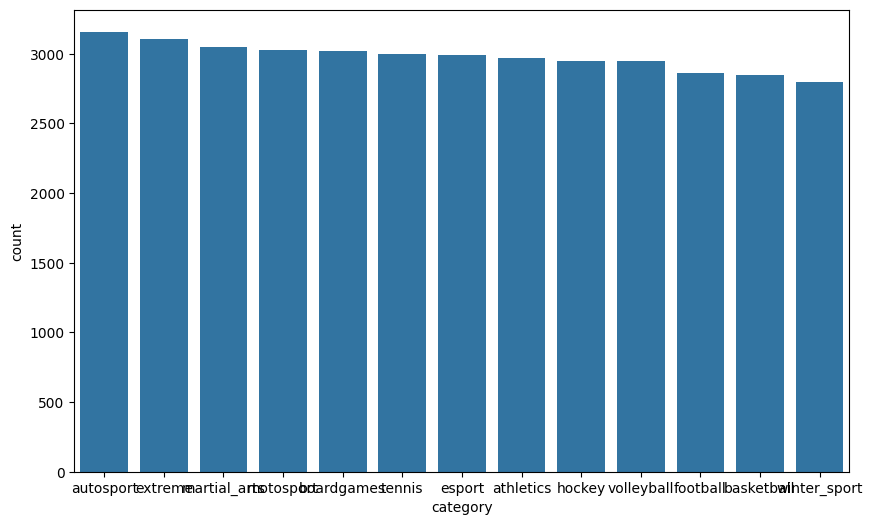

In [ ]:
sentence_outliers = df[df["processed_text"] == ""]
print(f"Sentence outliers detected: {sentence_outliers}\n")

df = df.dropna()

class_distribution = df["category"].value_counts()
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel("category")
plt.ylabel("count")
plt.show()

In [ ]:
for cls in df["category"].unique():
    text = " ".join(df[df["category"] == cls]["processed_text"])

    wordcloud = WordCloud(
        width=400,
        height=200,
        collocations=False,
        background_color="white",
    ).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud)
    plt.title(str(cls))
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X = df["processed_text"]
y = df["category"]

X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(
    X,
    y,
    random_state=SEED,
    stratify=y,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


выводы:
1. балансировать не обязательно, так как примерно все на одном уровне
2. пустые предложения отсутствуют

## 3. Тематическое моделирование

In [ ]:
def compute_coherence_values(
    dictionary,
    corpus,
    texts,
    limit: int,
    passes: int,
    chunksize: int,
    iterations: int,
    start: int,
    step: int,
    eval_every=None,
):
    """
        Compute c_v coherence for various number of topics
        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model
    with respective number of topics
    """
    temp = dictionary[0]
    id2word = dictionary.id2token
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha="auto",
            eta="auto",
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
chunksize = 5000
passes = 10
iterations = 150
eval_every = None
start = THEME_COUNT_START
limit = THEME_COUNT_END
step = 1


texts = [text.split() for text in X_train_src]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(
    limit=limit,
    passes=passes,
    start=start,
    step=step,
    chunksize=chunksize,
    iterations=iterations,
    dictionary=dictionary,
    corpus=corpus,
    texts=texts,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


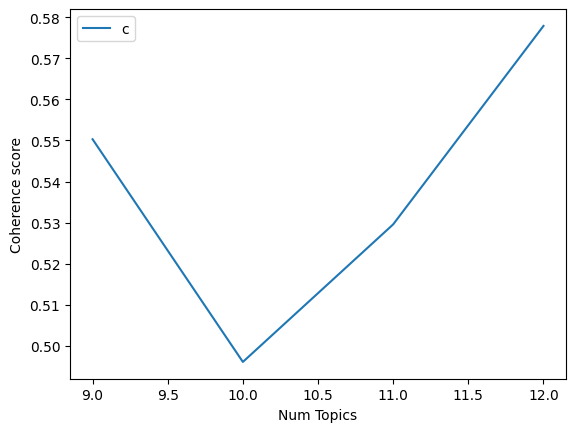

In [ ]:
x = range(start, limit + 1, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [ ]:
best_model_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_model_index]

lda_display = gensimvis.prepare(best_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def theme_vectorizer(
    model: LdaModel,
    dictionary: Dictionary,
    X_train: pd.Series,
    X_test: pd.Series,
):
    def topics_to_vector(topic_probs, num_topics):
        vector = np.zeros(num_topics)
        for topic_num, prob in topic_probs:
            vector[topic_num] = prob
        return vector

    X_train_topics = [model[dictionary.doc2bow(text.split())] for text in X_train]
    X_test_topics = [model[dictionary.doc2bow(text.split())] for text in X_test]

    num_topics = model.num_topics

    X_train_vectors = np.array(
        [topics_to_vector(topics, num_topics) for topics in X_train_topics]
    )
    X_test_vectors = np.array(
        [topics_to_vector(topics, num_topics) for topics in X_test_topics]
    )

    return X_train_vectors, X_test_vectors


X_train_vectors, X_test_vectors = theme_vectorizer(
    model=best_model,
    dictionary=dictionary,
    X_train=X_train_src,
    X_test=X_test_src,
)

svm = SVC(probability=True, random_state=SEED)
svm.fit(X_train_vectors, y_train_src)

y_train_pred = svm.predict(X_train_vectors)
y_test_pred = svm.predict(X_test_vectors)

cl_rep_train = classification_report(y_train_src, y_train_pred, output_dict=True)
cl_rep_test = classification_report(y_test_src, y_test_pred, output_dict=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
RESULT["svc"] = {
    "accuracy_train": cl_rep_train["accuracy"],
    "accuracy_test": cl_rep_test["accuracy"],
    "model": svm,
    "params": None,
    "X_train": X_train_vectors,
    "X_test": X_test_vectors,
    "y_train": y_train_src,
    "y_test": y_test_src,
    "vectorizer": None,
}

print(cl_rep_train["accuracy"], cl_rep_test["accuracy"])

0.42846325933574253 0.4249870934434693


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. Градиентный бустинг

In [ ]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_src)
y_test_encoded = label_encoder.transform(y_test_src)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def objective(trial, X, y, cv_folds=5):
    params = {
        "iterations": trial.suggest_int("iterations", MIN_ITERS, MAX_ITERS),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "loss_function": "MultiClass",
    }

    cv = StratifiedKFold(
        n_splits=cv_folds,
        shuffle=True,
        random_state=SEED,
    )
    scores = []

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = CatBoostClassifier(
            **params,
            verbose=0,
            random_state=SEED,
        )

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=50,
            verbose=False,
        )

        preds = model.predict(X_valid)
        fold_score = f1_score(y_valid, preds, average="weighted")
        scores.append(fold_score)

    return np.mean(scores)


def train_catboost_with_optuna(
    name: str,
    vectorizer,
    X_train,
    y_train,
    X_test,
    y_test,
    n_trials: int = 100,
    cv_folds: int = 5,
    params: dict = None,
    timeout: float = None,
    force: bool = False,
):
    def go_study():
        study = optuna.create_study(direction="maximize")

        study.optimize(
            lambda trial: objective(
                trial=trial,
                X=X_train,
                y=y_train,
                cv_folds=cv_folds,
            ),
            n_trials=n_trials,
            timeout=timeout,
            show_progress_bar=True,
        )

        return study.best_params

    if force == False:
        if params == None:
            if name in RESULT:
                print(
                    f"name: {name}, train: {RESULT[name]['accuracy_train']}, test: {RESULT[name]['accuracy_test']}"
                )
                return RESULT[name]["model"]
            else:
                params = go_study()
        else:
            pass

    else:
        if not params:
            params = go_study()

    final_model = CatBoostClassifier(
        **params,
        verbose=0,
        random_state=SEED,
    )

    final_model.fit(X_train, y_train)

    y_train_pred = final_model.predict(X_train)
    y_test_pred = final_model.predict(X_test)

    cl_rep_train = classification_report(y_train, y_train_pred, output_dict=True)
    cl_rep_test = classification_report(y_test, y_test_pred, output_dict=True)

    RESULT[name] = {
        "accuracy_train": cl_rep_train["accuracy"],
        "accuracy_test": cl_rep_test["accuracy"],
        "model": final_model,
        "params": params,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "vectorizer": vectorizer,
    }
    train_cl = cl_rep_train["accuracy"]
    test_cl = cl_rep_test["accuracy"]
    print(
        f"name: {name}, train: {train_cl}, test: {test_cl}"
    )

    return final_model

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1. В методах преобразования данных пробуйте различные параметры, в поисках лучших для решения текущей задачи
2. Не забывайте про подбор параметров у самого бустинга с помощью optuna

https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

### Мешок слов

In [ ]:
vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

print(X_train.shape)

train_catboost_with_optuna(
    name="bow",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
    force=True,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 08:46:40,088] A new study created in memory with name: no-name-70290ba1-1508-49d7-b09f-282797b31110


(29055, 100)


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 08:49:49,745] Trial 0 finished with value: 0.4332821903801556 and parameters: {'iterations': 230, 'learning_rate': 0.021915171693843317, 'depth': 6, 'l2_leaf_reg': 1.9603810825455936e-05, 'random_strength': 1.3287290498929994e-06, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.4332821903801556.
[I 2025-02-07 08:50:17,821] Trial 1 finished with value: 0.3924471798333329 and parameters: {'iterations': 192, 'learning_rate': 0.017538037635940765, 'depth': 5, 'l2_leaf_reg': 0.1651036307060614, 'random_strength': 2.022146118852631e-05, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.4332821903801556.
[I 2025-02-07 08:50:48,396] Trial 2 finished with value: 0.4530438893518053 and parameters: {'iterations': 224, 'learning_rate': 0.08680327784869131, 'depth': 5, 'l2_leaf_reg': 3.710261505006894, 'random_strength': 4.049290899198919e-06, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.4530438893518053.
[I 2025-02-07 08:51:09,263] Trial 3 finished with value: 0.4

### Мешок слов + n-grams

In [ ]:
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

train_catboost_with_optuna(
    name="bow_n",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 08:52:26,168] A new study created in memory with name: no-name-d48bd5c6-6a5c-4f66-9bed-b88102b71ce4


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 08:52:57,886] Trial 0 finished with value: 0.22520882264328448 and parameters: {'iterations': 174, 'learning_rate': 0.0012379870898323558, 'depth': 4, 'l2_leaf_reg': 4.2613147786270675e-05, 'random_strength': 8.84586529122846e-08, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.22520882264328448.
[I 2025-02-07 08:54:21,381] Trial 1 finished with value: 0.2579036984082103 and parameters: {'iterations': 141, 'learning_rate': 0.0015115474720148944, 'depth': 6, 'l2_leaf_reg': 0.0005458952141773256, 'random_strength': 1.1144749287119955e-08, 'min_data_in_leaf': 21}. Best is trial 1 with value: 0.2579036984082103.
[I 2025-02-07 08:56:54,422] Trial 2 finished with value: 0.44544693209664554 and parameters: {'iterations': 272, 'learning_rate': 0.049442535486560316, 'depth': 6, 'l2_leaf_reg': 2.275644813341555, 'random_strength': 3.573309839210504, 'min_data_in_leaf': 22}. Best is trial 2 with value: 0.44544693209664554.
[I 2025-02-07 08:57:30,040] Trial 3 finished with valu

### Мешок слов + m-skip-n-grams

In [ ]:
class SkipGramVectorizer(CountVectorizer):
    def build_analyzer(self):
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
            compose(
                tokenize,
                preprocess,
                self.decode,
            )(doc)
        )

    def _word_skip_grams(self, tokens):
        return compose(cmap(" ".join), pluck([0, 2]), sliding_window(3))(tokens)


vectorizer = SkipGramVectorizer(
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

train_catboost_with_optuna(
    name="bow_n_m",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:01:03,759] A new study created in memory with name: no-name-60bab149-fd11-4736-8e60-c889c119a2f3


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:01:15,350] Trial 0 finished with value: 0.14214476076710308 and parameters: {'iterations': 195, 'learning_rate': 0.04276219724561901, 'depth': 5, 'l2_leaf_reg': 0.09063028685841631, 'random_strength': 0.019259439080974727, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.14214476076710308.
[I 2025-02-07 09:01:25,205] Trial 1 finished with value: 0.12167151415769738 and parameters: {'iterations': 173, 'learning_rate': 0.013943427225002192, 'depth': 4, 'l2_leaf_reg': 5.257477626022335, 'random_strength': 0.028755180407456477, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.14214476076710308.
[I 2025-02-07 09:01:38,346] Trial 2 finished with value: 0.10754422947729973 and parameters: {'iterations': 241, 'learning_rate': 0.001872305092883856, 'depth': 5, 'l2_leaf_reg': 5.840793959009397e-08, 'random_strength': 0.00012381774633474246, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.14214476076710308.
[I 2025-02-07 09:01:44,731] Trial 3 finished with value:

### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

train_catboost_with_optuna(
    name="tfidf",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:02:55,579] A new study created in memory with name: no-name-43d6128c-e06c-4a61-8869-054f4d0f98a3


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:04:21,799] Trial 0 finished with value: 0.4177797650721138 and parameters: {'iterations': 215, 'learning_rate': 0.08042439211097732, 'depth': 5, 'l2_leaf_reg': 53.755525199131, 'random_strength': 0.6964145298625823, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.4177797650721138.
[I 2025-02-07 09:07:07,236] Trial 1 finished with value: 0.45954311996063163 and parameters: {'iterations': 166, 'learning_rate': 0.07713959241372441, 'depth': 6, 'l2_leaf_reg': 0.005578737120575057, 'random_strength': 2.3716387141722984e-05, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.45954311996063163.
[I 2025-02-07 09:07:59,197] Trial 2 finished with value: 0.41693311574107195 and parameters: {'iterations': 199, 'learning_rate': 0.030335347458490595, 'depth': 4, 'l2_leaf_reg': 0.026693011601596248, 'random_strength': 7.019851322965246e-05, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.45954311996063163.
[I 2025-02-07 09:08:27,299] Trial 3 finished with value: 0.21

### TF-IDF + n-grams

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

train_catboost_with_optuna(
    name="tfidf_n",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:12:36,301] A new study created in memory with name: no-name-77f68b67-af35-4657-8a05-6fc1acf3de51


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:13:03,048] Trial 0 finished with value: 0.2555666233963696 and parameters: {'iterations': 101, 'learning_rate': 0.002701573985920505, 'depth': 4, 'l2_leaf_reg': 0.04523819109741566, 'random_strength': 1.360814649642857e-07, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.2555666233963696.
[I 2025-02-07 09:14:39,857] Trial 1 finished with value: 0.29234714582604837 and parameters: {'iterations': 236, 'learning_rate': 0.0029914687215467305, 'depth': 5, 'l2_leaf_reg': 7.222450825194162e-06, 'random_strength': 0.012989943295177227, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.29234714582604837.
[I 2025-02-07 09:16:16,335] Trial 2 finished with value: 0.41692990407978625 and parameters: {'iterations': 238, 'learning_rate': 0.024187336079591296, 'depth': 5, 'l2_leaf_reg': 2.5458106128402918, 'random_strength': 0.10485975240697193, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.41692990407978625.
[I 2025-02-07 09:16:57,854] Trial 3 finished with value: 

### TF-IDF + m-skip-n-grams

In [ ]:
class SkipGramVectorizerTf(TfidfVectorizer):
    def build_analyzer(self):
        preprocess = self.build_preprocessor()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
            compose(
                tokenize,
                preprocess,
                self.decode,
            )(doc)
        )

    def _word_skip_grams(self, tokens):
        return compose(cmap(" ".join), pluck([0, 2]), sliding_window(3))(tokens)


vectorizer = SkipGramVectorizerTf(
    max_features=MAX_FEATURES,
    max_df=MAX_DF,
    min_df=MIN_DF,
)

X_train = vectorizer.fit_transform(X_train_src)
X_test = vectorizer.transform(X_test_src)

train_catboost_with_optuna(
    name="tfidf_n_m",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_encoded,
    X_test=X_test,
    y_test=y_test_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:19:58,354] A new study created in memory with name: no-name-b17a9ca8-0d3c-4f2a-bf48-4acfdcfca0d9


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:20:09,599] Trial 0 finished with value: 0.1372425354838127 and parameters: {'iterations': 180, 'learning_rate': 0.08159182666181188, 'depth': 5, 'l2_leaf_reg': 28.89800540687481, 'random_strength': 0.021476248393858744, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.1372425354838127.
[I 2025-02-07 09:20:23,784] Trial 1 finished with value: 0.13838992158824606 and parameters: {'iterations': 276, 'learning_rate': 0.007435611036485367, 'depth': 4, 'l2_leaf_reg': 0.000386496689491947, 'random_strength': 8.788704741166638, 'min_data_in_leaf': 29}. Best is trial 1 with value: 0.13838992158824606.
[I 2025-02-07 09:20:34,611] Trial 2 finished with value: 0.14203940061106965 and parameters: {'iterations': 196, 'learning_rate': 0.04167475104376413, 'depth': 4, 'l2_leaf_reg': 0.4518803024732252, 'random_strength': 0.0003087531338532608, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.14203940061106965.
[I 2025-02-07 09:21:18,406] Trial 3 finished with value: 0.11194

In [ ]:
print_results()

Model: svc
Train accuracy: 0.42846325933574253
Test accuracy: 0.4249870934434693

Model: bow
Train accuracy: 0.45682326621923935
Test accuracy: 0.43004646360351056

Model: bow_n
Train accuracy: 0.4677680261572879
Test accuracy: 0.439855446566856

Model: bow_n_m
Train accuracy: 0.15845809671313027
Test accuracy: 0.1588022715539494

Model: tfidf
Train accuracy: 0.4695921528136293
Test accuracy: 0.43551884357253484

Model: tfidf_n
Train accuracy: 0.4012390294269489
Test accuracy: 0.39029426948890034

Model: tfidf_n_m
Train accuracy: 0.15684047496128034
Test accuracy: 0.15828600929272071



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Генерация искусственных данных и балансировка классов

Выберите лучшее представление данных, опираясь на метрику. Попробуйте сбалансировать классы с помощью весов (параметр catboost), если выше этого не делали. Попробуйте сгенерировать новые данные для классов, в которых меньше всего объектов. Генерация представляет собой семплирование токенов из всего множества токенов определенного класса. Обучите модель на новом датасете, сравните качество.

1. признаки предложений (длина предложений, наличие орф.знаков, количество предложений в тексте)
2. обработка опечаток (расстояние между словом нормальным и словом с опечаткой)
3. склеивание с частицей не.

In [ ]:
best_catboost_model_name = None
mx_score = -np.inf

for key in RESULT.keys():
    if key == "svc":
        continue

    if RESULT[key]["accuracy_test"] > mx_score:
        mx_score = RESULT[key]["accuracy_test"]
        best_catboost_model_name = key

best_catboost_model_name

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'bow_n'

In [ ]:
# балансировка

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded,
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

params = RESULT[best_catboost_model_name]["params"] | {
    "class_weights": class_weights_dict,
}

model = CatBoostClassifier(**params)

model.fit(RESULT[best_catboost_model_name]["X_train"], y_train_encoded, silent=True)

y_train_pred = model.predict(RESULT[best_catboost_model_name]["X_train"])
y_test_pred = model.predict(RESULT[best_catboost_model_name]["X_test"])

cl_rep_train = classification_report(y_train_encoded, y_train_pred, output_dict=True)
cl_rep_test = classification_report(y_test_encoded, y_test_pred, output_dict=True)

RESULT["balanced"] = {
    "accuracy_train": cl_rep_train["accuracy"],
    "accuracy_test": cl_rep_test["accuracy"],
    "model": model,
    "params": params,
    "X_train": RESULT[best_catboost_model_name]["X_train"],
    "X_test": RESULT[best_catboost_model_name]["X_test"],
    "y_train": y_train_encoded,
    "y_test": y_test_encoded,
    "vectorizer": vectorizer,
}

train_cl = cl_rep_train["accuracy"]
test_cl = cl_rep_test["accuracy"]

print(
    f"name: balanced, train: {train_cl}, test: {test_cl}"
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


name: balanced, train: 0.4700395801066942, test: 0.4401652039235932


In [ ]:
# генерация искусственных данных

class_counts = df["category"].value_counts()
mean_count = class_counts.mean()
underrepresented = class_counts[class_counts < mean_count]

mean_token_len = defaultdict(list)
class_tokens = defaultdict(list)

for category, text in zip(df["category"], df["processed_text"]):
    tokens = text.split()
    mean_token_len[category].append(len(tokens))
    class_tokens[category].extend(tokens)

synthetic_texts = []
synthetic_labels = []

for category in underrepresented.index:
    samples_to_generate = int(mean_count - class_counts[category])
    tokens_pool = class_tokens[category]

    avg_len = int(sum(mean_token_len[category]) / len(mean_token_len[category]))

    print(category, avg_len)

    for _ in range(samples_to_generate):
        num_tokens = random.randint(avg_len - 2, avg_len + 2)
        synthetic_text = " ".join(random.choices(tokens_pool, k=num_tokens))
        synthetic_texts.append(process_text(synthetic_text))
        synthetic_labels.append(category)

print()
print(len(synthetic_texts), len(synthetic_labels), "\n")
print(synthetic_texts[:5], synthetic_labels[:5])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


athletics 42
hockey 30
volleyball 27
football 24
basketball 23
winter_sport 36

500 500 

['почта выступить скорость брифинг бегов ленин наспорт технология сдаться атлет гладкий алексей найтон выдавать йог спасибо дух королеваспорт заслуга сабля спасибо найроби фото происходить зож трейл снег количество старт доступный ветер дистанция пакет старт многие экс белок финишер количество автобус позволить помнить голландка', 'испугаться старт спринт болеть масаев энергия сравнивать напоминать сила пятница санга официально предотвратить прийти коляска работа судорога любовь упражнение момент порог живот публикация мышца заполнять всесторонний бег делисьбегом жирный пожалуйста школа километр выпустить выжимать прямой классный бег участие успеть необходимо', 'поднять устать польский отличный тренировка турнир держать километр нога приходиться растягивать киев упражнение амый вторсырье будущий обучение переварить подавление ультра сегодняшний кушнарев нога полис выносливость вкусно продолжать во

In [ ]:
df

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,oid,category,text,processed_text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,волшебный фото виктория поплавский евгениямедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,возвращение подземелье треш эйфория тупость жа...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,чешский вратарь доминик доминатор гашек петр т...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,warhammer валрак решить подкормить сильно свеж...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,шестеркин затаскивать рейнджерс восточный конф...
...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,битный буря накрыть пиксель автомобиль нуждать...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,ир сидоркова объяснять сказаться машина жестки...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,ракетка хорват марин чилич обыграть испанец ал...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,известный календарь мужской сборная розыгрыш л...


In [ ]:
def get_text_features(text):
    sentences = text.split(".")
    return {
        "token_count": len(text.split()),
        "avg_token_len": np.mean([len(token) for token in text.split()]),
        "sentence_length": np.mean([len(s.split()) for s in sentences if s.strip()]),
        # "punctuation_count": sum(1 for c in text if c in string.punctuation), не нужно, так как знаки чистятся
    }


df_augmented = pd.DataFrame(
    {
        "text": list(df["processed_text"]) + synthetic_texts,
        "category": list(df["category"]) + synthetic_labels,
    }
)

text_features = pd.DataFrame([get_text_features(text) for text in df_augmented["text"]])

df_augmented = pd.concat([df_augmented, text_features], axis=1)

df_augmented

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,category,token_count,avg_token_len,sentence_length
0,волшебный фото виктория поплавский евгениямедв...,winter_sport,5,9.200000,5.0
1,возвращение подземелье треш эйфория тупость жа...,extreme,15,8.066667,15.0
2,чешский вратарь доминик доминатор гашек петр т...,football,67,6.761194,67.0
3,warhammer валрак решить подкормить сильно свеж...,boardgames,84,7.154762,84.0
4,шестеркин затаскивать рейнджерс восточный конф...,hockey,180,7.961111,180.0
...,...,...,...,...,...
39235,место де тодоренко спортсмен валерий кроме мар...,winter_sport,38,6.710526,38.0
39236,обстоятельство снег искренне фигурист самолет ...,winter_sport,38,7.684211,38.0
39237,программа путь аэрокузбасс депутат регулярно н...,winter_sport,34,7.411765,34.0
39238,евгениятарас молодежь идеально страна евгений ...,winter_sport,34,7.705882,34.0


In [ ]:
vectorizer = RESULT[best_catboost_model_name]["vectorizer"]

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    df_augmented.drop("category", axis=1),
    df_augmented["category"],
    random_state=SEED,
    stratify=df_augmented["category"],
)

y_train_aug_encoded = label_encoder.fit_transform(y_train_aug)
y_test_aug_encoded = label_encoder.transform(y_test_aug)

X_train = pd.concat(
    [
        pd.DataFrame(vectorizer.fit_transform(X_train_aug["text"]).A).reset_index(
            drop=True
        ),
        pd.DataFrame(X_train_aug.drop("text", axis=1).values.tolist()),
    ],
    axis=1,
    ignore_index=True,
).values

X_test = pd.concat(
    [
        pd.DataFrame(vectorizer.transform(X_test_aug["text"]).A).reset_index(drop=True),
        pd.DataFrame(X_test_aug.drop("text", axis=1).values.tolist()),
    ],
    axis=1,
    ignore_index=True,
).values

train_catboost_with_optuna(
    name="augmented",
    vectorizer=vectorizer,
    X_train=X_train,
    y_train=y_train_aug_encoded,
    X_test=X_test,
    y_test=y_test_aug_encoded,
    n_trials=N_TRIALS,
    cv_folds=CV_FOLDS,
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:25:27,025] A new study created in memory with name: no-name-5891ef4d-4c1c-4e3b-8888-493bc4ee7939


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:26:52,411] Trial 0 finished with value: 0.2557501559567392 and parameters: {'iterations': 139, 'learning_rate': 0.0014024627466905687, 'depth': 6, 'l2_leaf_reg': 2.8061471431544973e-08, 'random_strength': 0.02102935743986626, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.2557501559567392.
[I 2025-02-07 09:27:34,925] Trial 1 finished with value: 0.4686989021590686 and parameters: {'iterations': 243, 'learning_rate': 0.0590983257337058, 'depth': 5, 'l2_leaf_reg': 0.873789886727296, 'random_strength': 1.4435859278354902e-07, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.4686989021590686.
[I 2025-02-07 09:29:11,372] Trial 2 finished with value: 0.25337018049856985 and parameters: {'iterations': 151, 'learning_rate': 0.00133152246683238, 'depth': 6, 'l2_leaf_reg': 0.2596841842154227, 'random_strength': 1.236730987051252e-06, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.4686989021590686.
[I 2025-02-07 09:31:18,361] Trial 3 finished with value: 0.4

In [ ]:
print_results()

Model: svc
Train accuracy: 0.42846325933574253
Test accuracy: 0.4249870934434693

Model: bow
Train accuracy: 0.45682326621923935
Test accuracy: 0.43004646360351056

Model: bow_n
Train accuracy: 0.4677680261572879
Test accuracy: 0.439855446566856

Model: bow_n_m
Train accuracy: 0.15845809671313027
Test accuracy: 0.1588022715539494

Model: tfidf
Train accuracy: 0.4695921528136293
Test accuracy: 0.43551884357253484

Model: tfidf_n
Train accuracy: 0.4012390294269489
Test accuracy: 0.39029426948890034

Model: tfidf_n_m
Train accuracy: 0.15684047496128034
Test accuracy: 0.15828600929272071

Model: balanced
Train accuracy: 0.4700395801066942
Test accuracy: 0.4401652039235932

Model: augmented
Train accuracy: 0.49215086646279305
Test accuracy: 0.4612640163098879



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Понижение размерности

- уменьшите размерность векторов с помощью PCA, посмотрите, улучшается ли качество
- попробуйте несколько вариантов понижения размерности: от 90% до 50%
от изначального размера вектора.

In [ ]:
def evaluate_with_pca(
    X_train_vec,
    X_test_vec,
    dim_reduction_ratios=[0.9, 0.7, 0.5],
):
    results = {}
    n_features = X_train_vec.shape[1]

    for ratio in dim_reduction_ratios:
        n_components = int(n_features * ratio)
        vectorizer = PCA(n_components=n_components)

        X_train = vectorizer.fit_transform(X_train_vec)
        X_test = vectorizer.transform(X_test_vec)

        train_catboost_with_optuna(
            name=f"{best_catboost_model_name}_pca_{ratio}",
            vectorizer=vectorizer,
            X_train=X_train,
            y_train=y_train_encoded,
            X_test=X_test,
            y_test=y_test_encoded,
            n_trials=N_TRIALS,
            cv_folds=CV_FOLDS,
        )

    return results

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
evaluate_with_pca(
    RESULT[best_catboost_model_name]["X_train"],
    RESULT[best_catboost_model_name]["X_test"],
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[I 2025-02-07 09:36:06,540] A new study created in memory with name: no-name-8d163202-6c4a-4265-bb1d-59624c0d9706


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:40:30,975] Trial 0 finished with value: 0.4512920522847228 and parameters: {'iterations': 289, 'learning_rate': 0.06029652032264795, 'depth': 6, 'l2_leaf_reg': 1.5336776224515504e-08, 'random_strength': 0.019923847536244762, 'min_data_in_leaf': 23}. Best is trial 0 with value: 0.4512920522847228.
[I 2025-02-07 09:42:23,554] Trial 1 finished with value: 0.3560684788651574 and parameters: {'iterations': 272, 'learning_rate': 0.0074496738022182115, 'depth': 5, 'l2_leaf_reg': 0.0006377870760474857, 'random_strength': 9.00253119781977e-06, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.4512920522847228.
[I 2025-02-07 09:43:02,678] Trial 2 finished with value: 0.25199881973616484 and parameters: {'iterations': 150, 'learning_rate': 0.003148877202263011, 'depth': 4, 'l2_leaf_reg': 1.8592981102923973, 'random_strength': 0.00028036012030626154, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.4512920522847228.
[I 2025-02-07 09:44:00,798] Trial 3 finished with value:

[I 2025-02-07 09:49:29,745] A new study created in memory with name: no-name-424db2cb-593b-4637-a1d3-85ca718c1390


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 09:50:15,269] Trial 0 finished with value: 0.2676575027846117 and parameters: {'iterations': 141, 'learning_rate': 0.0019717058800015554, 'depth': 5, 'l2_leaf_reg': 6.98609694052149e-08, 'random_strength': 7.275727897603638e-07, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.2676575027846117.
[I 2025-02-07 09:51:20,375] Trial 1 finished with value: 0.38291317363670396 and parameters: {'iterations': 291, 'learning_rate': 0.014566326218001328, 'depth': 4, 'l2_leaf_reg': 0.02449782061542256, 'random_strength': 1.4941434762703594, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.38291317363670396.
[I 2025-02-07 09:54:52,903] Trial 2 finished with value: 0.3647066492854887 and parameters: {'iterations': 299, 'learning_rate': 0.0053675888930174625, 'depth': 6, 'l2_leaf_reg': 8.007320768972566e-08, 'random_strength': 1.610592827119054e-05, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.38291317363670396.
[I 2025-02-07 09:58:10,384] Trial 3 finished with value

[I 2025-02-07 10:03:06,546] A new study created in memory with name: no-name-460b3b55-10cc-4499-a4bd-3c2bef6f086e


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-02-07 10:05:02,523] Trial 0 finished with value: 0.30915105325482595 and parameters: {'iterations': 216, 'learning_rate': 0.0017853764516139437, 'depth': 6, 'l2_leaf_reg': 0.004972230201122917, 'random_strength': 0.0012455275855785977, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.30915105325482595.
[I 2025-02-07 10:05:58,851] Trial 1 finished with value: 0.3785436157993496 and parameters: {'iterations': 106, 'learning_rate': 0.01774622458105825, 'depth': 6, 'l2_leaf_reg': 1.7000800101741852e-07, 'random_strength': 0.9057854590763872, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.3785436157993496.
[I 2025-02-07 10:08:18,754] Trial 2 finished with value: 0.41540714604652307 and parameters: {'iterations': 270, 'learning_rate': 0.01668286616207846, 'depth': 6, 'l2_leaf_reg': 0.0005495257439812403, 'random_strength': 1.240879058766594e-07, 'min_data_in_leaf': 19}. Best is trial 2 with value: 0.41540714604652307.
[I 2025-02-07 10:09:22,446] Trial 3 finished with va

{}

In [58]:
print_results()

Model: svc
Train accuracy: 0.42846325933574253
Test accuracy: 0.4249870934434693

Model: bow
Train accuracy: 0.45682326621923935
Test accuracy: 0.43004646360351056

Model: bow_n
Train accuracy: 0.4677680261572879
Test accuracy: 0.439855446566856

Model: bow_n_m
Train accuracy: 0.15845809671313027
Test accuracy: 0.1588022715539494

Model: tfidf
Train accuracy: 0.4695921528136293
Test accuracy: 0.43551884357253484

Model: tfidf_n
Train accuracy: 0.4012390294269489
Test accuracy: 0.39029426948890034

Model: tfidf_n_m
Train accuracy: 0.15684047496128034
Test accuracy: 0.15828600929272071

Model: balanced
Train accuracy: 0.4700395801066942
Test accuracy: 0.4401652039235932

Model: augmented
Train accuracy: 0.49215086646279305
Test accuracy: 0.4612640163098879

Model: bow_n_pca_0.9
Train accuracy: 0.5562897952159697
Test accuracy: 0.4485286525554982

Model: bow_n_pca_0.7
Train accuracy: 0.48707623472724143
Test accuracy: 0.42725864739287556

Model: bow_n_pca_0.5
Train accuracy: 0.45045603166

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 5. Интерпретация результатов

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

In [60]:
shap.initjs()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


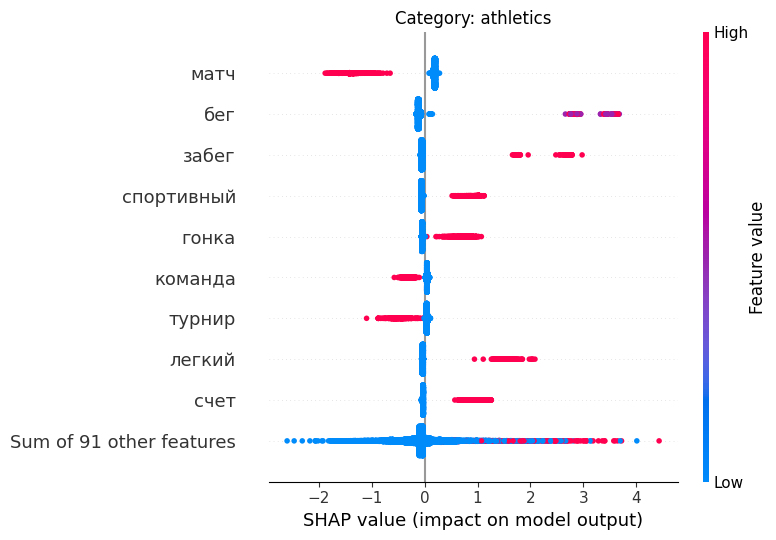

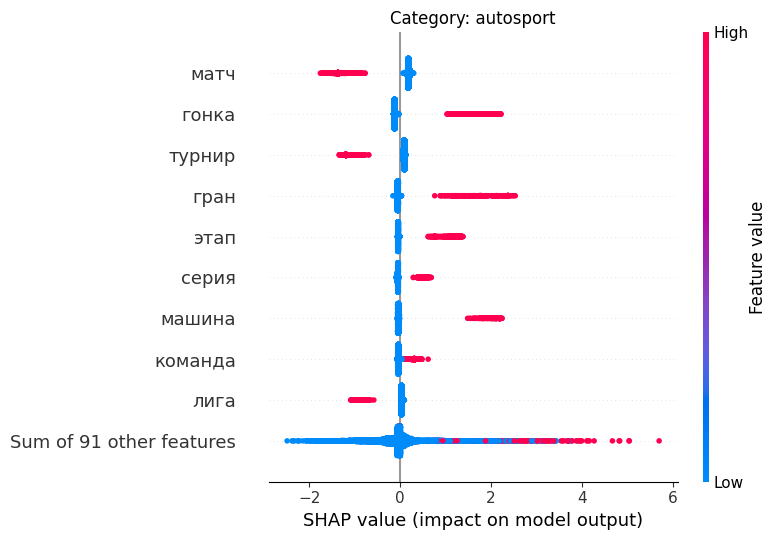

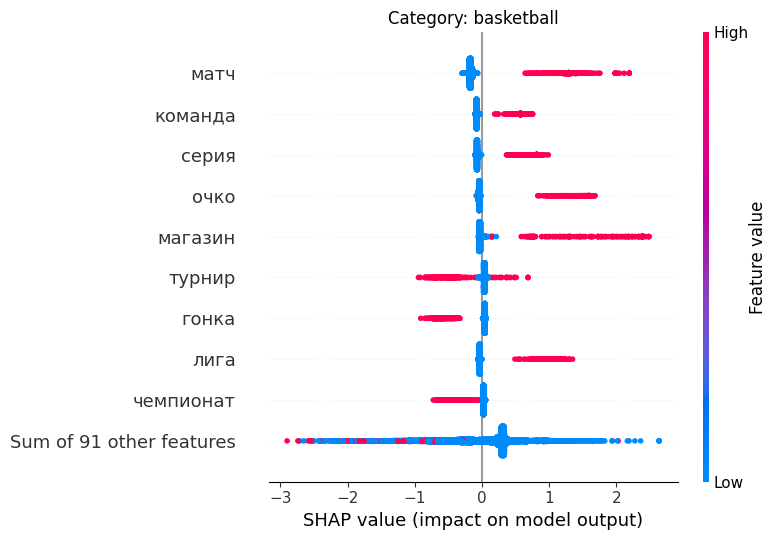

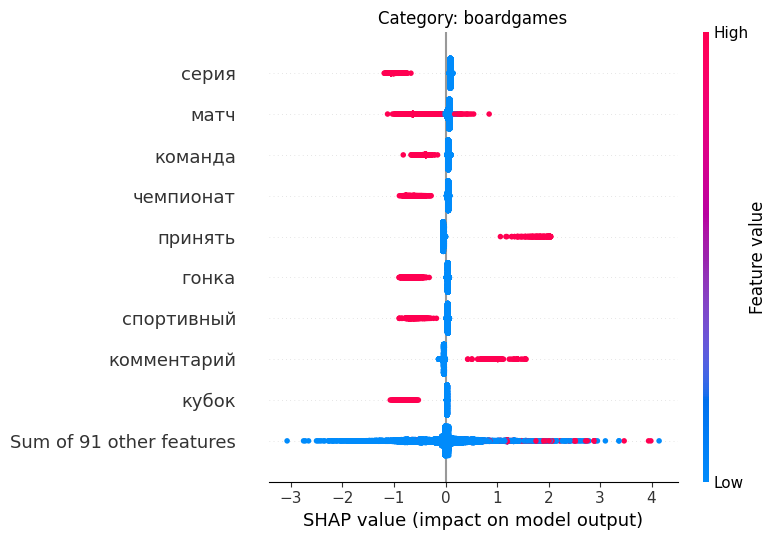

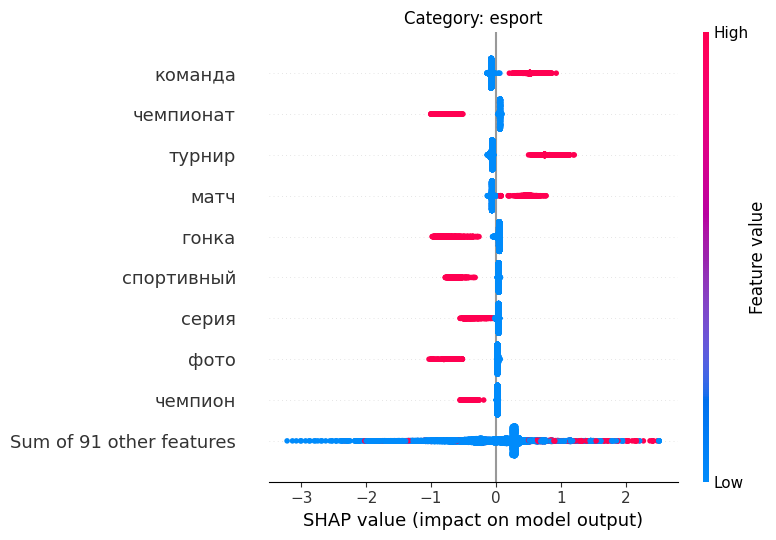

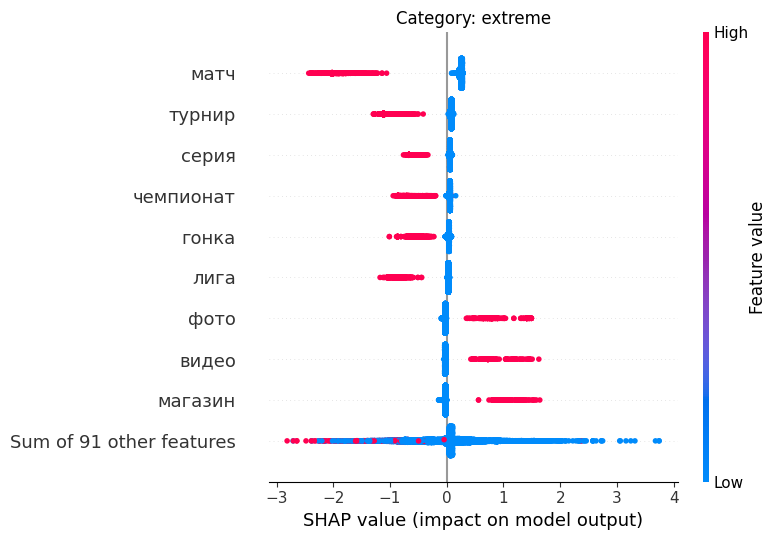

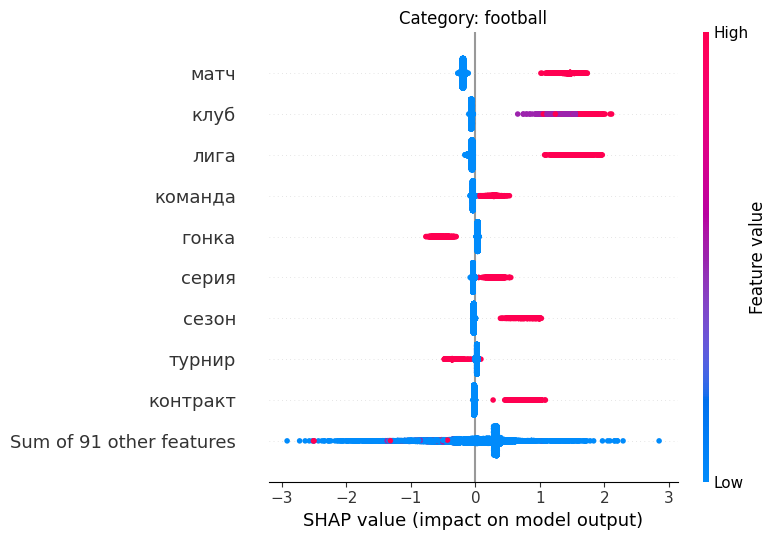

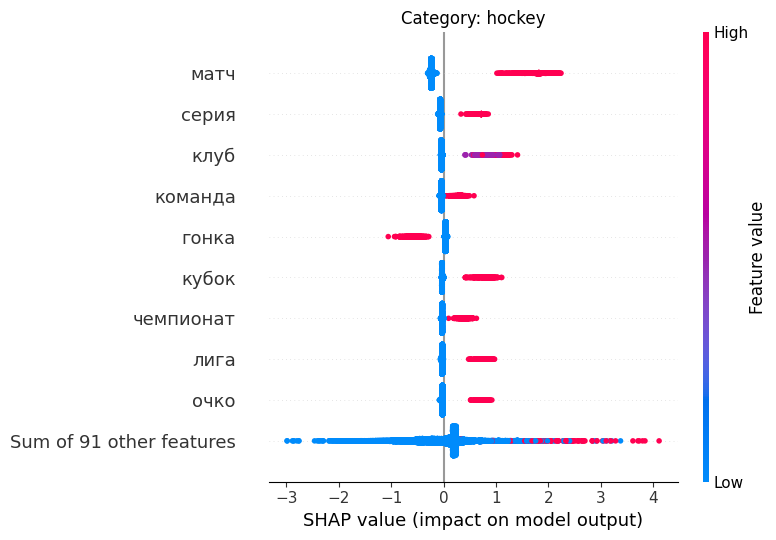

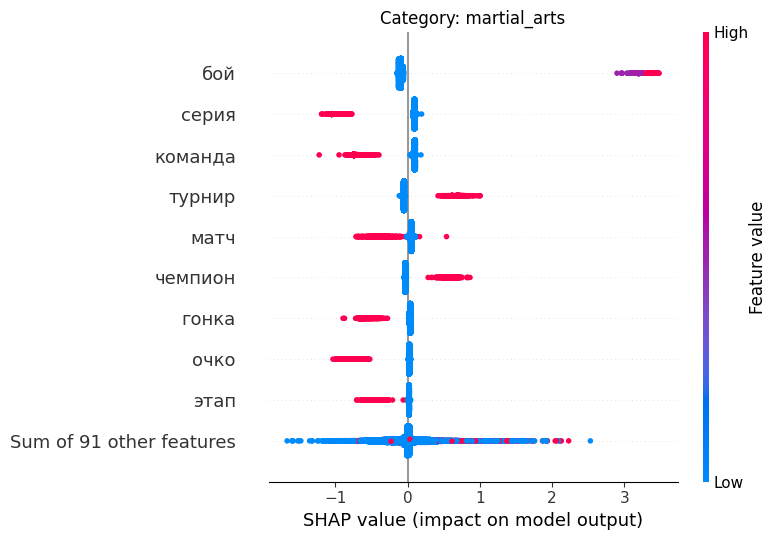

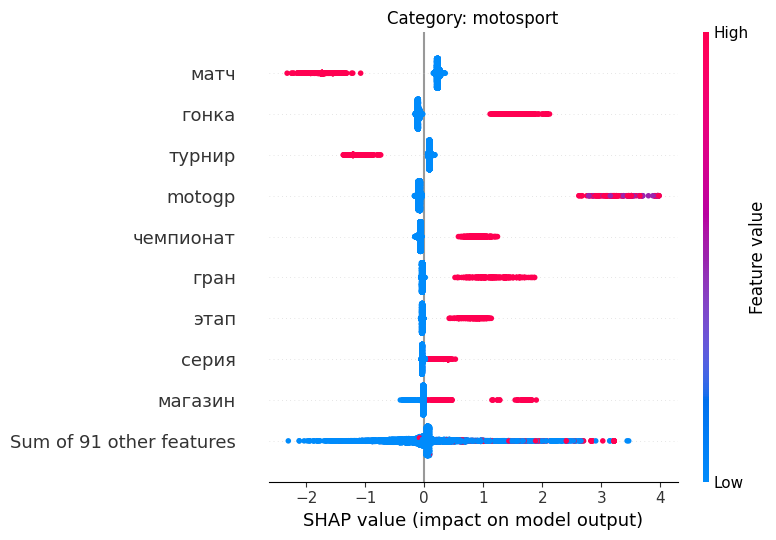

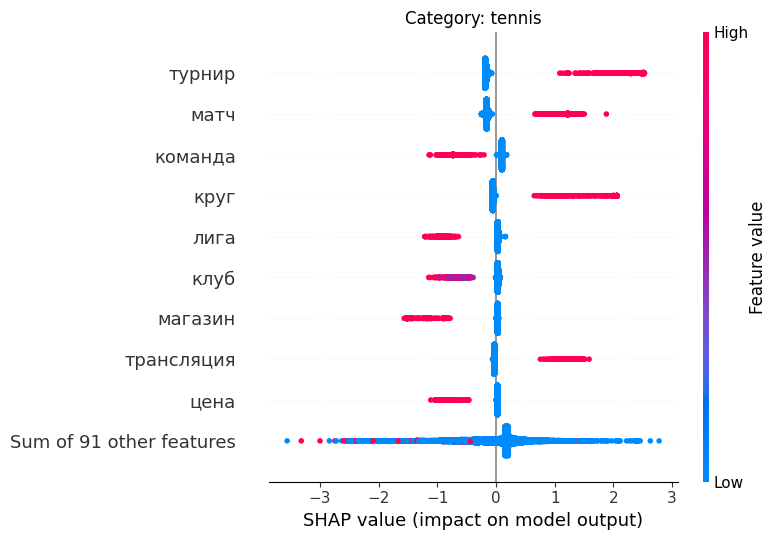

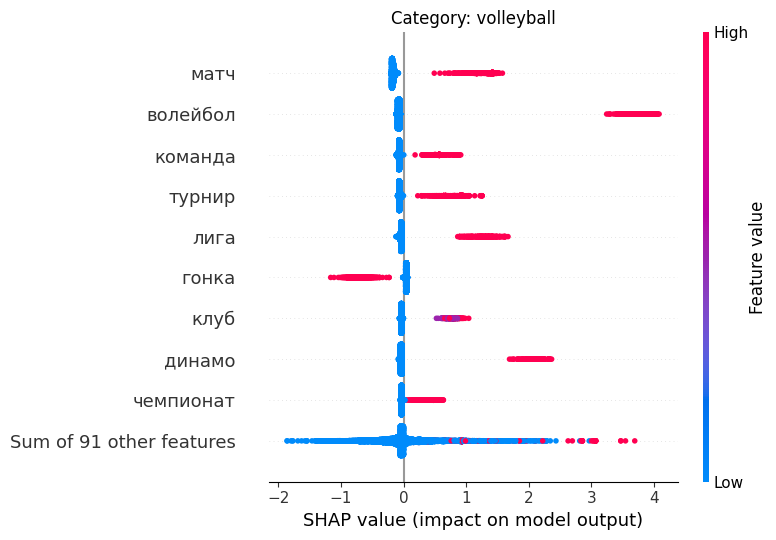

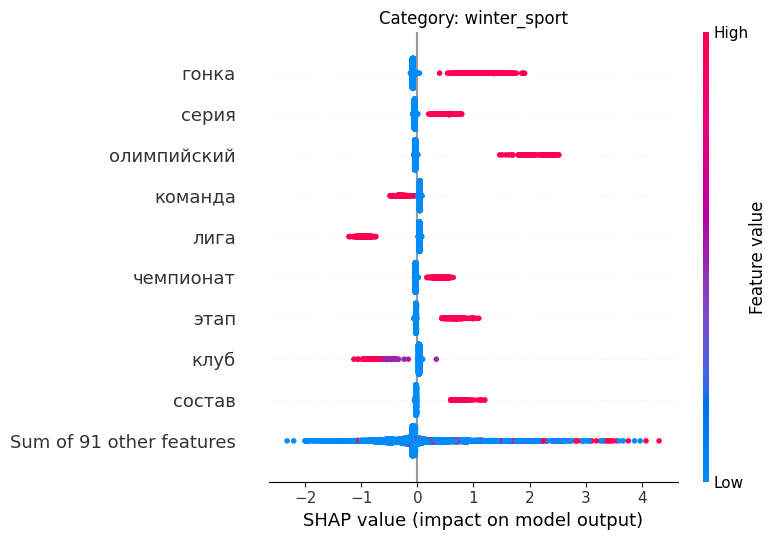

In [61]:
explainer = shap.Explainer(RESULT[best_catboost_model_name]["model"], seed=SEED)
sv = explainer(RESULT[best_catboost_model_name]["X_test"])

feature_names = (
    vectorizer.get_feature_names_out()
    if hasattr(vectorizer, "get_feature_names_out")
    else vectorizer.get_feature_names()
)

sv.feature_names = feature_names

for cat_id in np.unique(y_test_encoded):
    plt.figure()
    sp.beeswarm(sv[:, :, cat_id], max_display=10, show=False)
    plt.title(f"Category: {label_encoder.classes_[cat_id]}")
    plt.tight_layout()
    plt.show()

## Визуализация результатов

In [ ]:
# С помощью методов понижения размерности T-SNE И U-MAP взгляните
# на получившиеся векторные представления данных

tsne = TSNE(n_components=2, init="random")
X_tsne = tsne.fit_transform(RESULT[best_catboost_model_name]["X_test"])

umap = UMAP(n_components=2)
X_umap = umap.fit_transform(RESULT[best_catboost_model_name]["X_test"])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y_test_encoded,
)
plt.title("t-SNE Visualization")
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=y_test_encoded,
)
plt.title("UMAP Visualization")
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

In [63]:
end_dt = datetime.now()

end_dt - start_dt

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


datetime.timedelta(seconds=7250, microseconds=459361)